# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scrnatools as rna
import numpy as np
import pandas as pd
import pickle

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Import data

In [5]:
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [6]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs.h5ad")
scores = pd.read_csv("../analysis/entropy/cell_x_gene_atlas_cell_type_entropy.csv", index_col=0)
scores = scores[scores.index.isin(adata.var_names)].copy()
adata = adata[:, adata.var_names.isin(scores.index)].copy()

In [7]:
# cellxgene epithelial cells
cell_x_gene_exprs = np.load(f"{processedDataPath}cell_x_gene_atlas/expression/cell_x_gene_atlas_expression.npy")
genes = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/keep_genes.csv")["feature_name"]
cells = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/obs_names.csv")['0']
metadata = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/cell_metadata.csv", index_col=0)
cell_x_gene_exprs = pd.DataFrame(cell_x_gene_exprs, columns=genes)
cell_x_gene_exprs["cell_type"] = metadata.cell_type.values
cell_x_gene_exprs = cell_x_gene_exprs[cell_x_gene_exprs.cell_type.str.contains("epithelial")]
del cell_x_gene_exprs["cell_type"]
cell_x_gene_exprs = cell_x_gene_exprs[adata.var_names].copy()

# TRA fraction

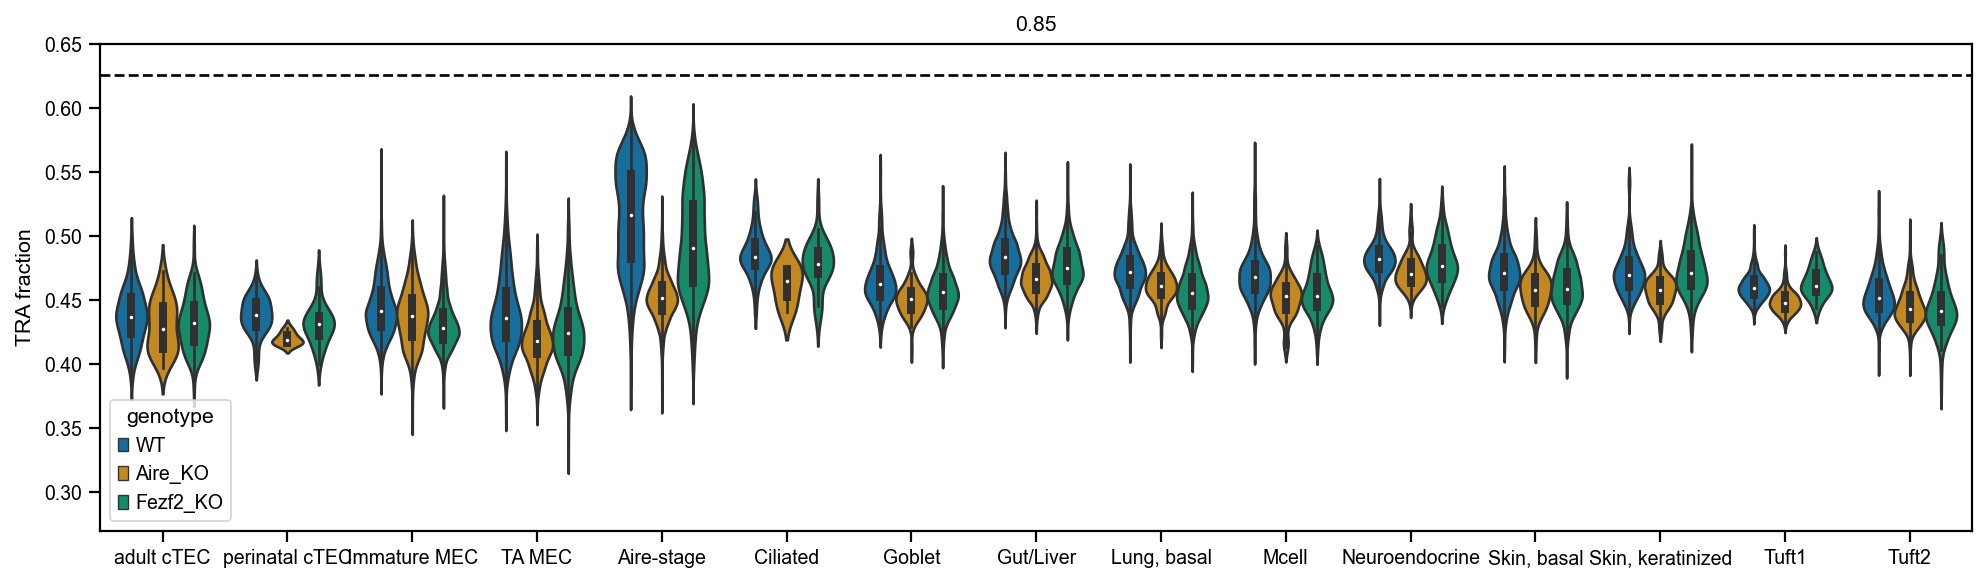

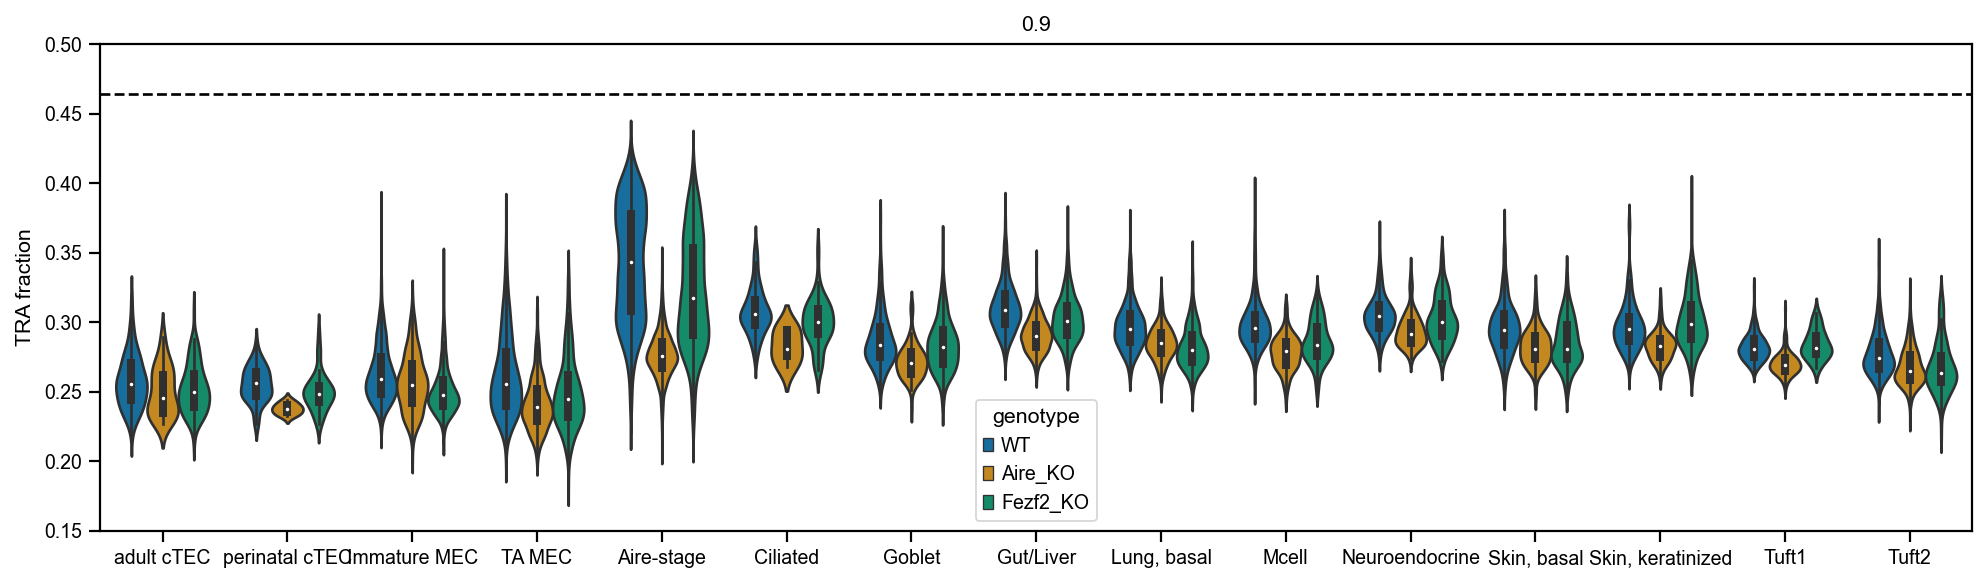

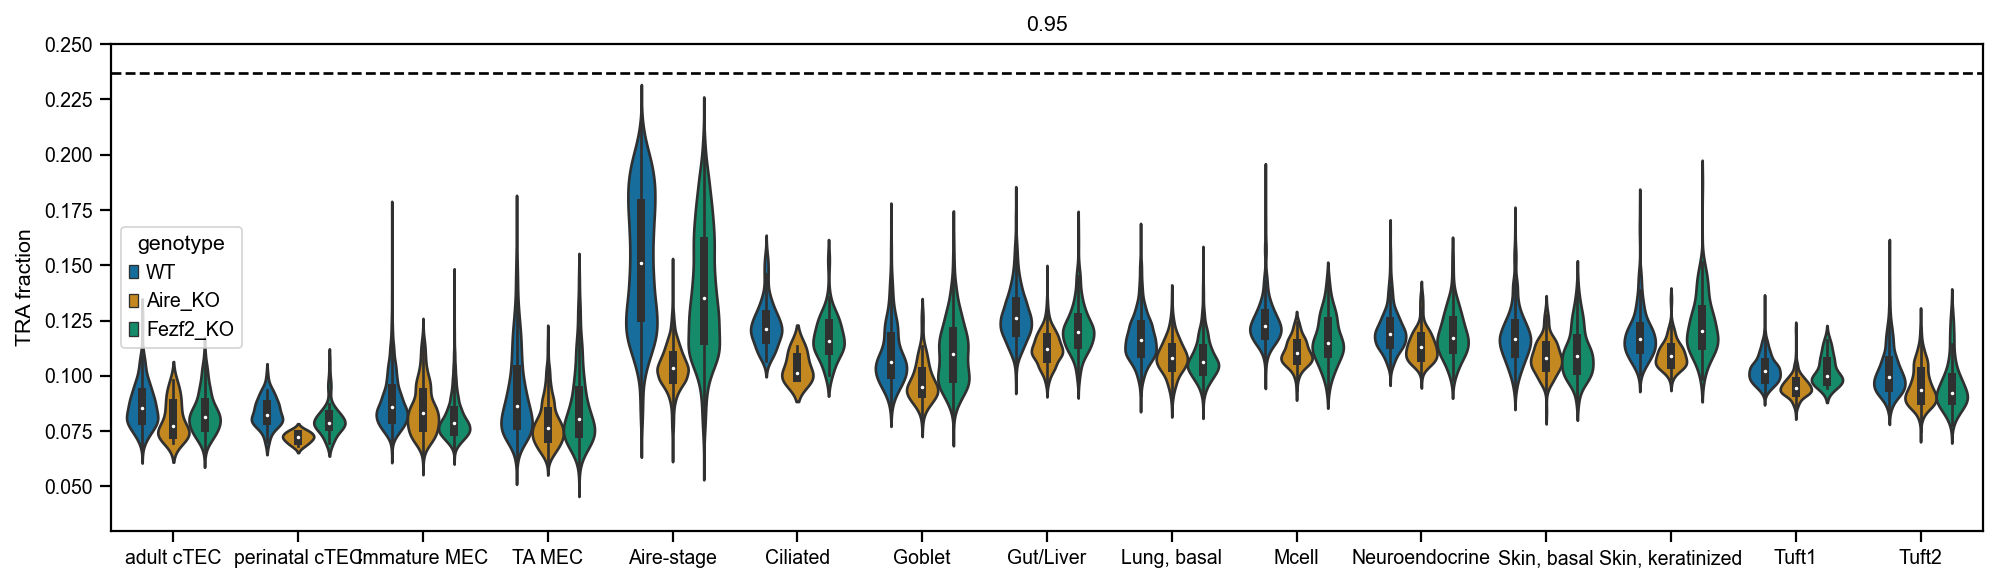

In [7]:
ylim = [(0.27, 0.65), (0.15, 0.5), (0.03, 0.25)]
for i,tau_threshold in enumerate([0.85, 0.9, 0.95]):
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    exprs = rna.tl.get_expression_matrix(adata, gene_data="scVI_normalized")
    exprs = exprs >= 0.1

    adata.obs[f"TRA_fraction_{tau_threshold}"] = exprs[TRAs].sum(axis=1)/exprs.sum(axis=1)
    adata.obs[f"TRA_number_{tau_threshold}"] = exprs[TRAs].sum(axis=1)

    plt.figure(figsize=(15,4))
    sns.violinplot(
        adata.obs,
        x="majority_voting",
        y=f"TRA_fraction_{tau_threshold}",
        hue="genotype",
        scale="width",
        width=0.75,
        hue_order=["WT", "Aire_KO", "Fezf2_KO"],
        palette=cmap[0:3],
        order=["adult cTEC", "perinatal cTEC", "Immature MEC", "TA MEC", 
               "Aire-stage", "Ciliated", "Goblet", "Gut/Liver", "Lung, basal",
               "Mcell", "Neuroendocrine", "Skin, basal", "Skin, keratinized", 
               "Tuft1", "Tuft2"]
    )
    plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
    plt.ylim(ylim[i][0], ylim[i][1])
    plt.xlabel("")
    plt.ylabel("TRA fraction")
    plt.title(tau_threshold)
    # plt.tight_layout()
    plt.savefig(f"../analysis/paper_figures/S4/S4D_{tau_threshold}_TRA_fraction.pdf")
    plt.show()

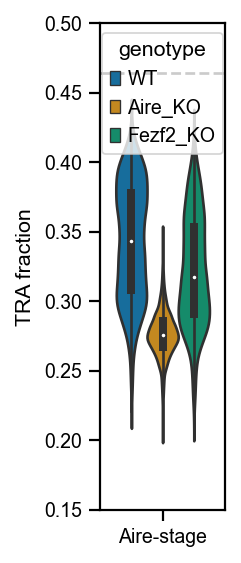

In [8]:
plt.figure(figsize=(1,4))
TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
sns.violinplot(
    adata[adata.obs.majority_voting == "Aire-stage"].obs,
    x="majority_voting",
    y=f"TRA_fraction_0.9",
    hue="genotype",
    scale="width",
    width=0.75,
    hue_order=["WT", "Aire_KO", "Fezf2_KO"],
    palette=cmap[0:3],
)
plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
plt.ylim(0.15, 0.5)
plt.xlabel("")
plt.ylabel("TRA fraction")
plt.savefig(f"../analysis/paper_figures/3/3B_TRA_fraction.pdf")
plt.show()

## cellxgene

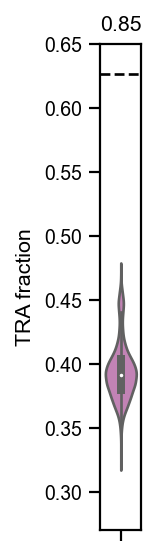

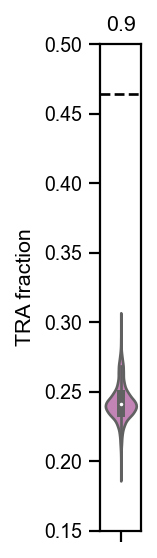

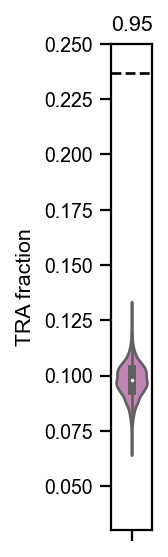

In [11]:
ylim = [(0.27, 0.65), (0.15, 0.5), (0.03, 0.25)]
cell_x_gene_TRA = cell_x_gene_exprs >= 0.1
for i,tau_threshold in enumerate([0.85, 0.9, 0.95]):
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    cell_x_gene_TRA[f"TRA_fraction_{tau_threshold}"] = cell_x_gene_TRA[TRAs].sum(axis=1)/cell_x_gene_TRA.sum(axis=1)

    plt.figure(figsize=(0.33,4))
    sns.violinplot(
        cell_x_gene_TRA,
        y=f"TRA_fraction_{tau_threshold}",
        scale="width",
        width=0.75,
        palette=[cmap[4]],
    )
    plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
    plt.ylim(ylim[i][0], ylim[i][1])
    plt.xlabel("")
    plt.ylabel("TRA fraction")
    plt.xticks(rotation=90)
    plt.title(tau_threshold)
    plt.savefig(f"../analysis/paper_figures/S4/S4D_{tau_threshold}_cellxgene_epithelium_TRA_fraction.pdf")
    plt.show()

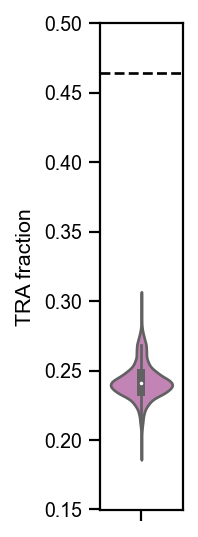

In [12]:
plt.figure(figsize=(0.66,4))
sns.violinplot(
    cell_x_gene_TRA,
    y=f"TRA_fraction_0.9",
    scale="width",
    width=0.75,
    palette=[cmap[4]]
)
TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
plt.ylim(0.15, 0.5)
plt.xlabel("")
plt.ylabel("TRA fraction")
plt.xticks(rotation=90)
plt.savefig(f"../analysis/paper_figures/3/3B_cellxgene_epithelium_TRA_fraction.pdf")
plt.show()

# DE genes

In [9]:
with open('../analysis/DE/filtered_genes.pkl', 'rb') as handle:
    filtered_genes = pickle.load(handle)

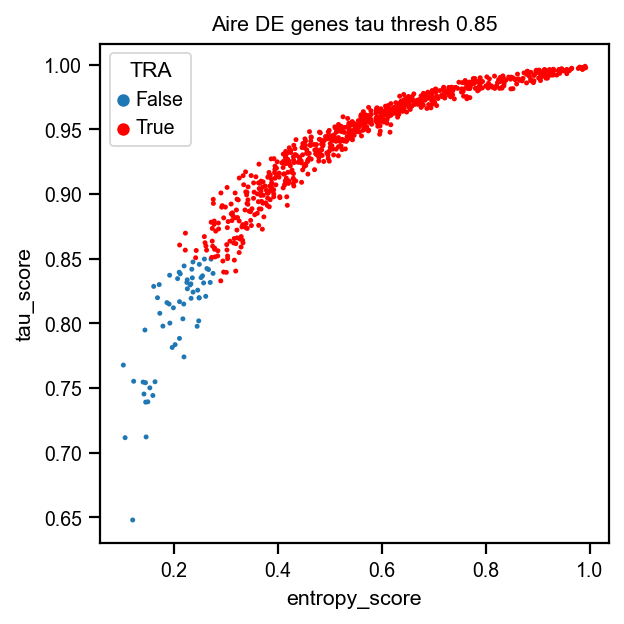

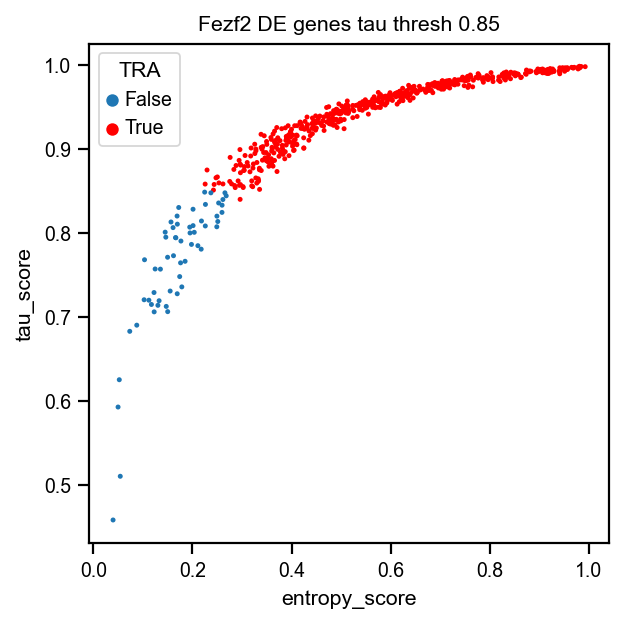

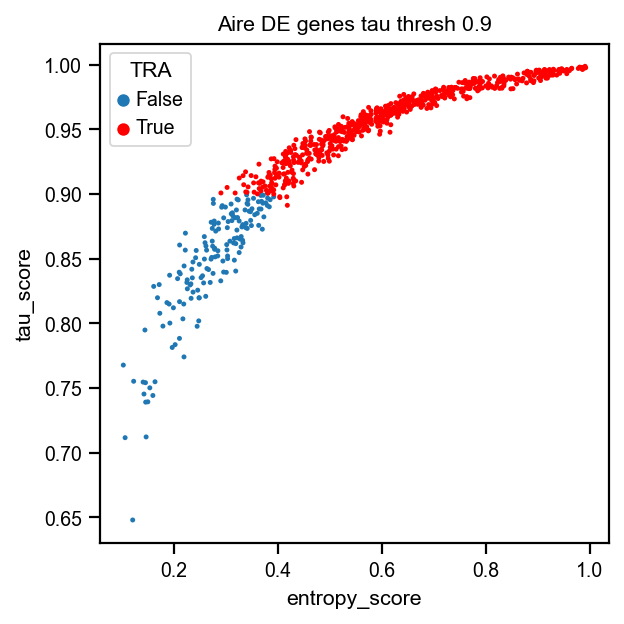

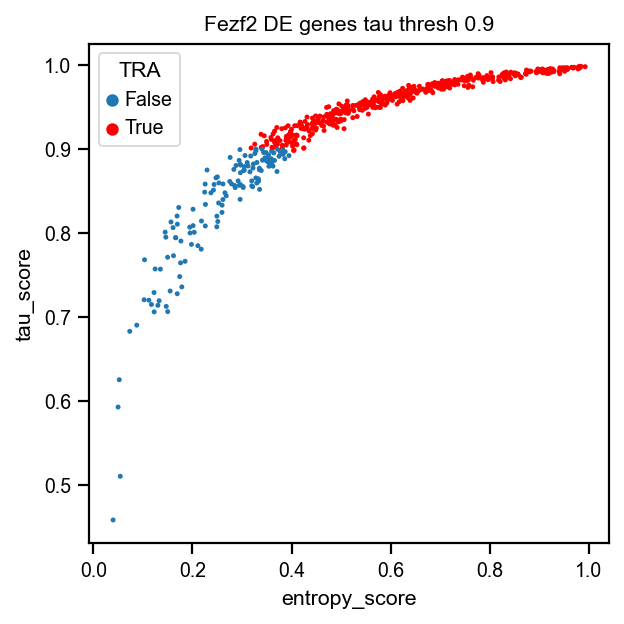

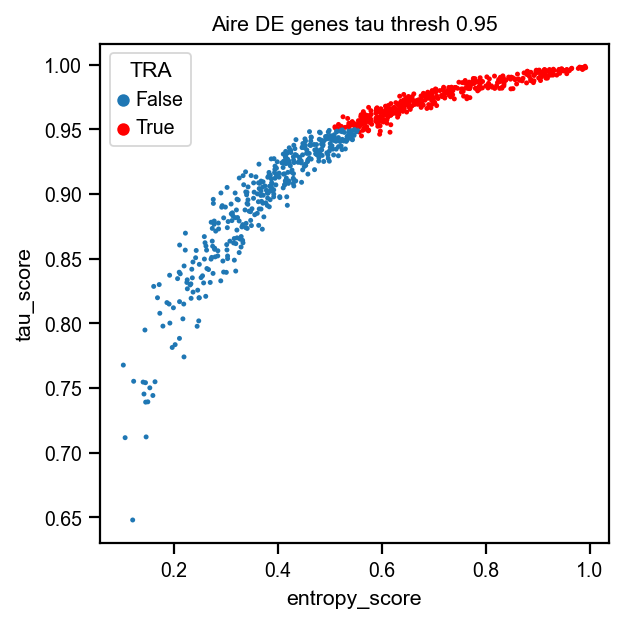

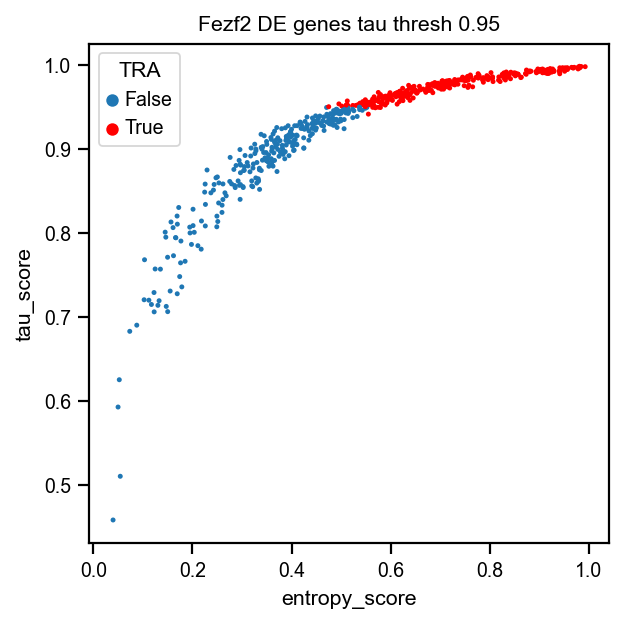

In [10]:
for i,tau_threshold in enumerate([0.85, 0.9, 0.95]):
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    for genotype in ["Aire", "Fezf2"]:
        filtered = filtered_genes[f"{genotype}_max_LFC"]
        filtered["tau_score"] = scores.tau_score
        filtered["entropy_score"] = scores.entropy_score
        filtered["TRA"] = filtered.index.isin(TRAs)

        fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
        sns.scatterplot(
            filtered,
            x="entropy_score",
            y="tau_score",
            hue="TRA",
            palette=["tab:blue", "red"],
            s=5,
            linewidth=0,
        )

        plt.title(f"{genotype} DE genes tau thresh {tau_threshold}")
        plt.tight_layout()
        if tau_threshold == 0.9:
            plt.savefig(f"../analysis/paper_figures/3/3C_{genotype}_DE_genes_{tau_threshold}_TRAs.pdf")
        else:
            plt.savefig(f"../analysis/paper_figures/S4/S4E_{genotype}_DE_genes_{tau_threshold}_TRAs.pdf")
        plt.show()
    

## Cellxgene expression of DE genes

In [11]:
cell_type_expression = np.load(f"{processedDataPath}/cell_x_gene_atlas/expression/cell_x_gene_atlas_cell_type_expression.npy")
index = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/cell_type_index.csv").cell_type
genes = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/keep_genes.csv").feature_name
cell_type_expression = pd.DataFrame(cell_type_expression, index=index, columns=genes)

Aire non-TRA


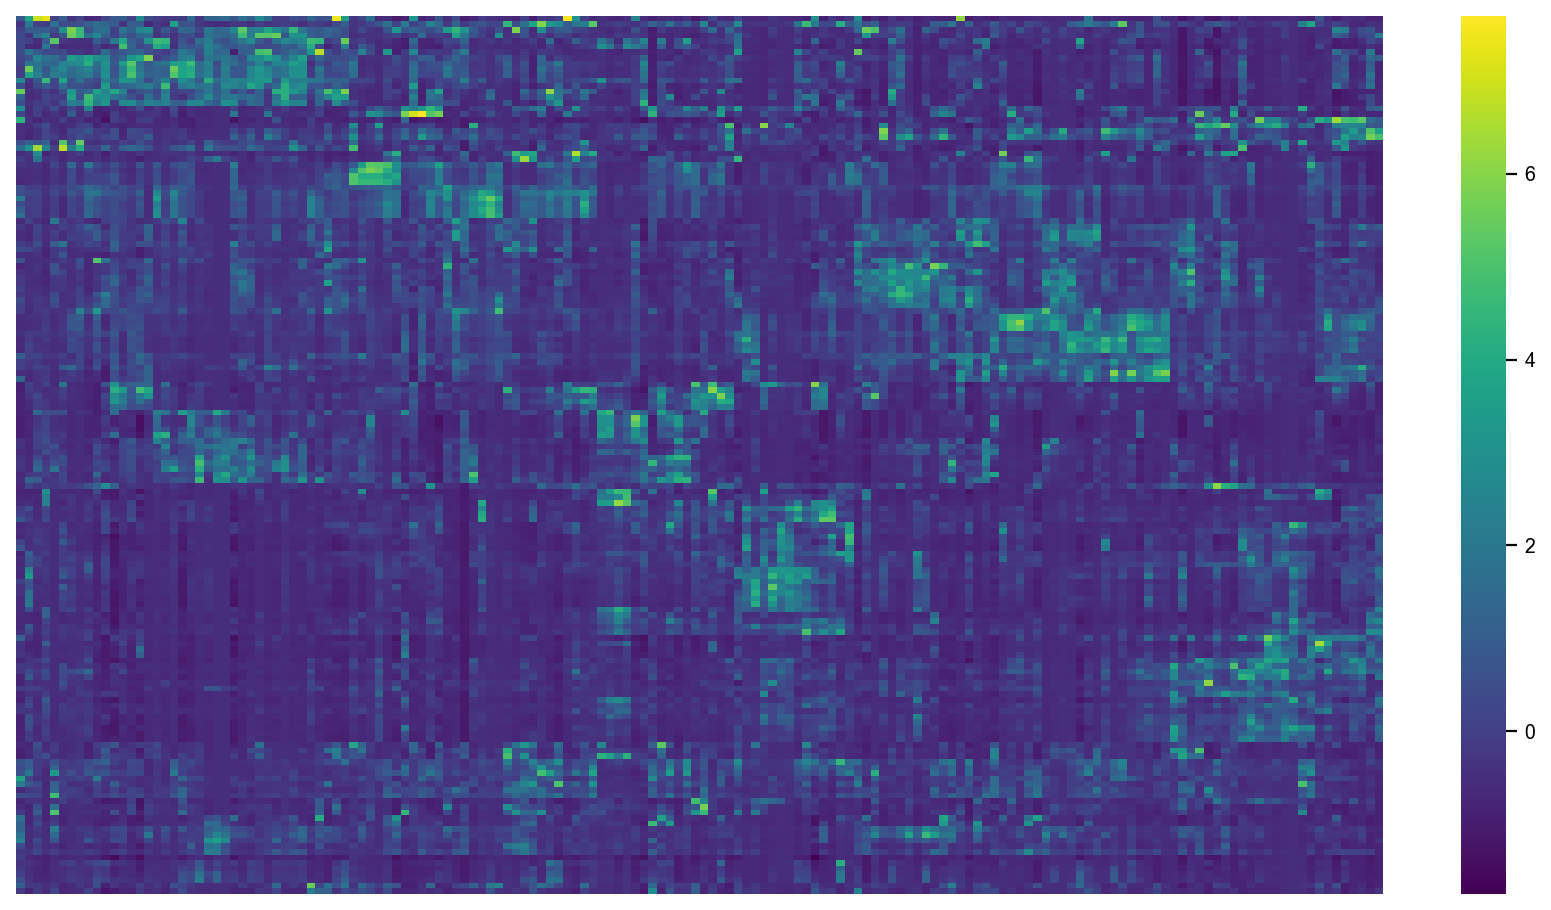

Aire TRA


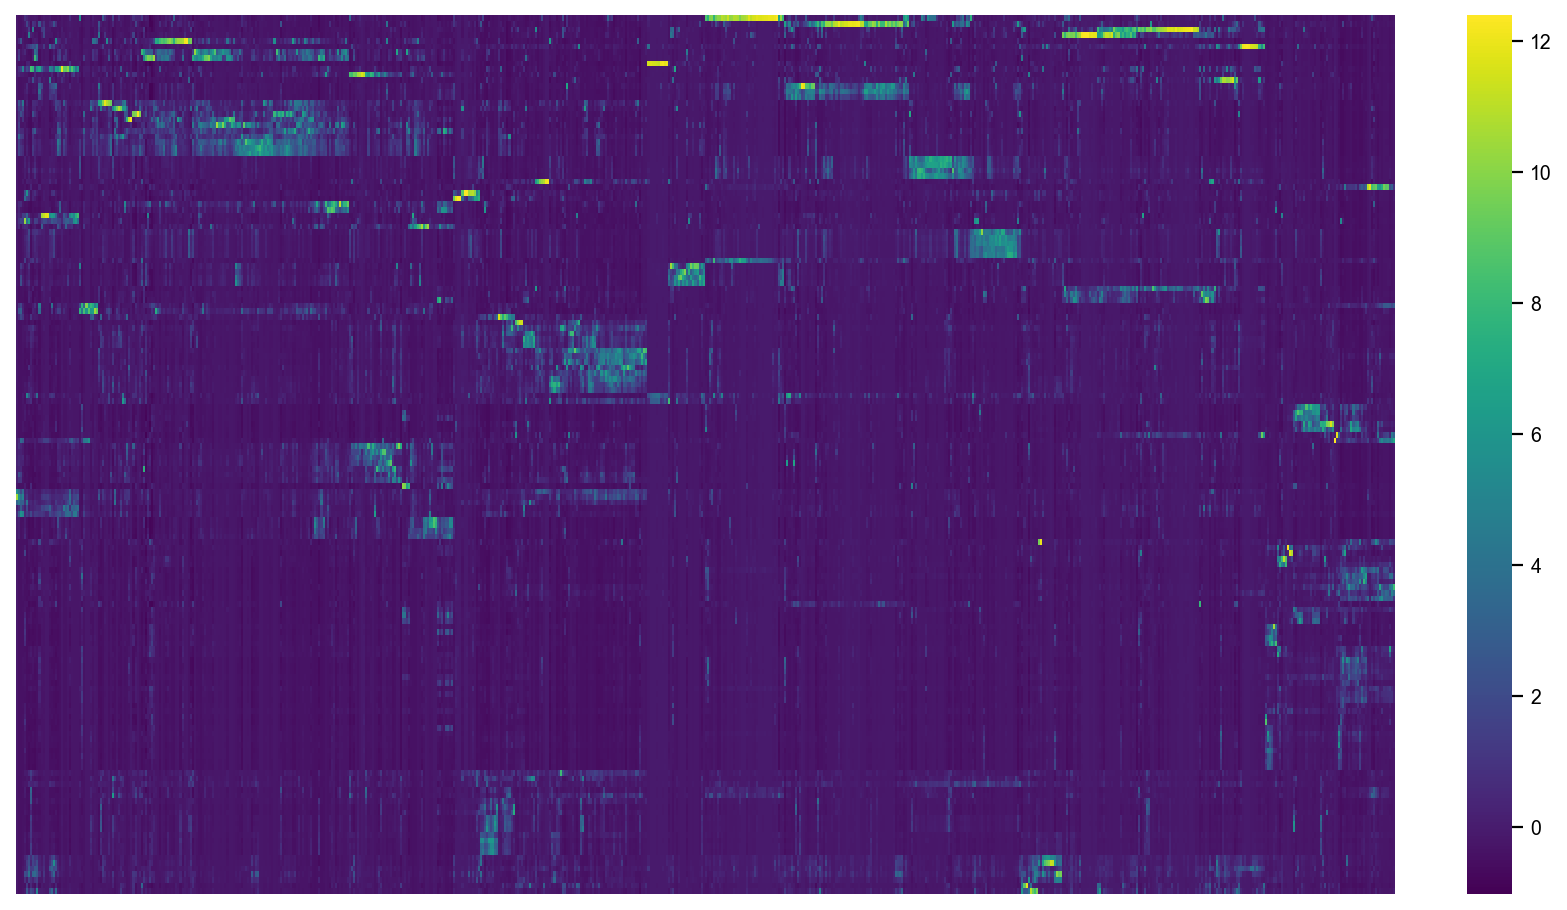

Fezf2 non-TRA


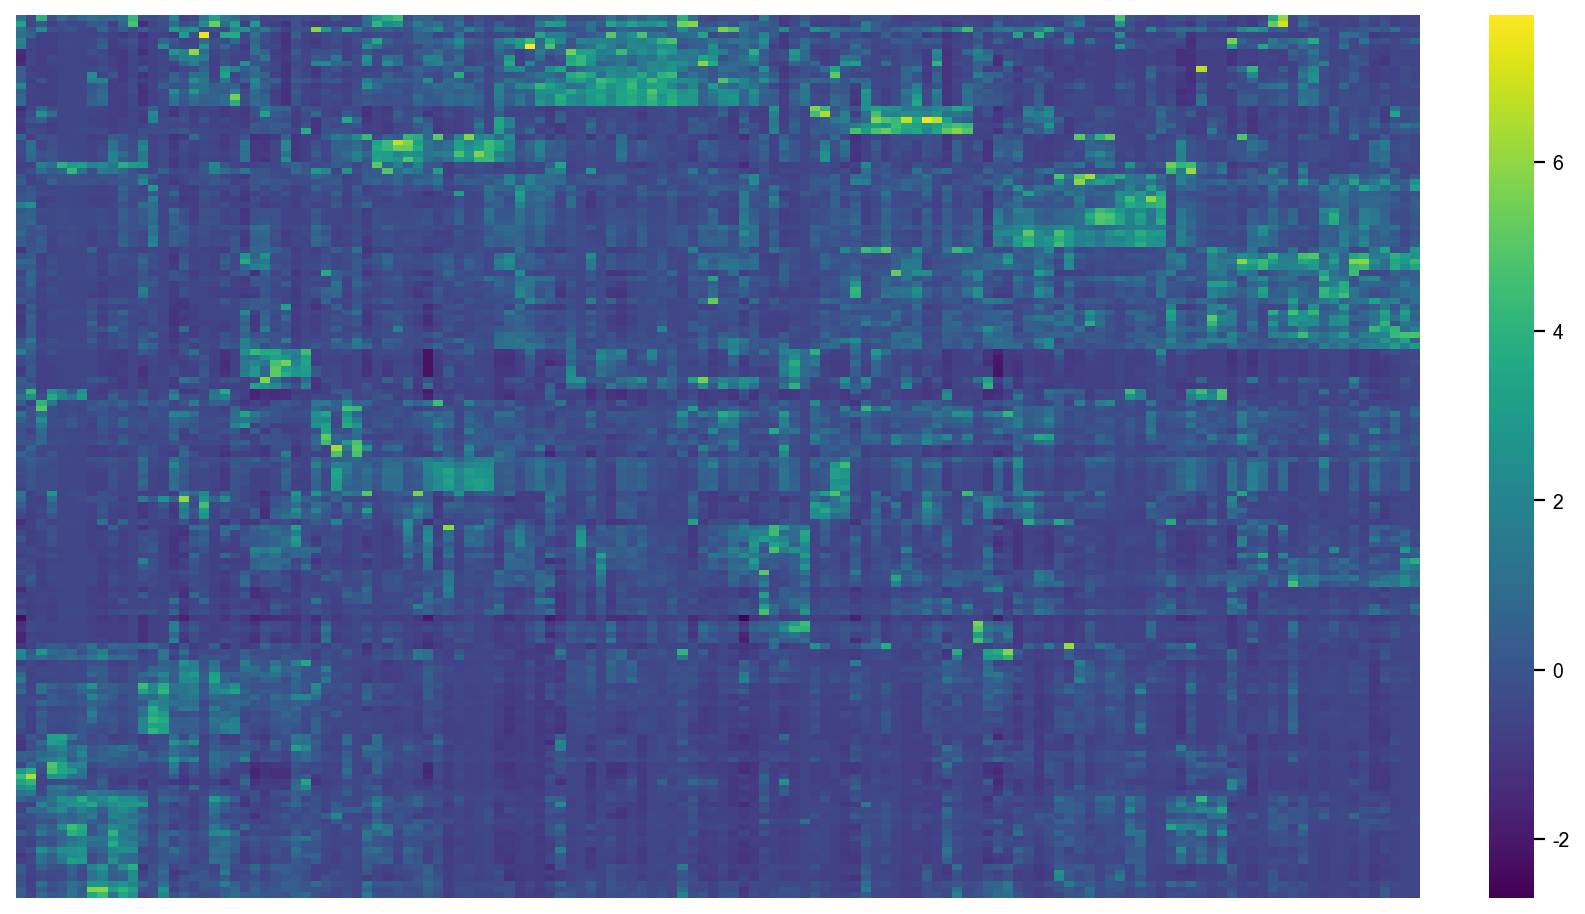

Fezf2 TRA


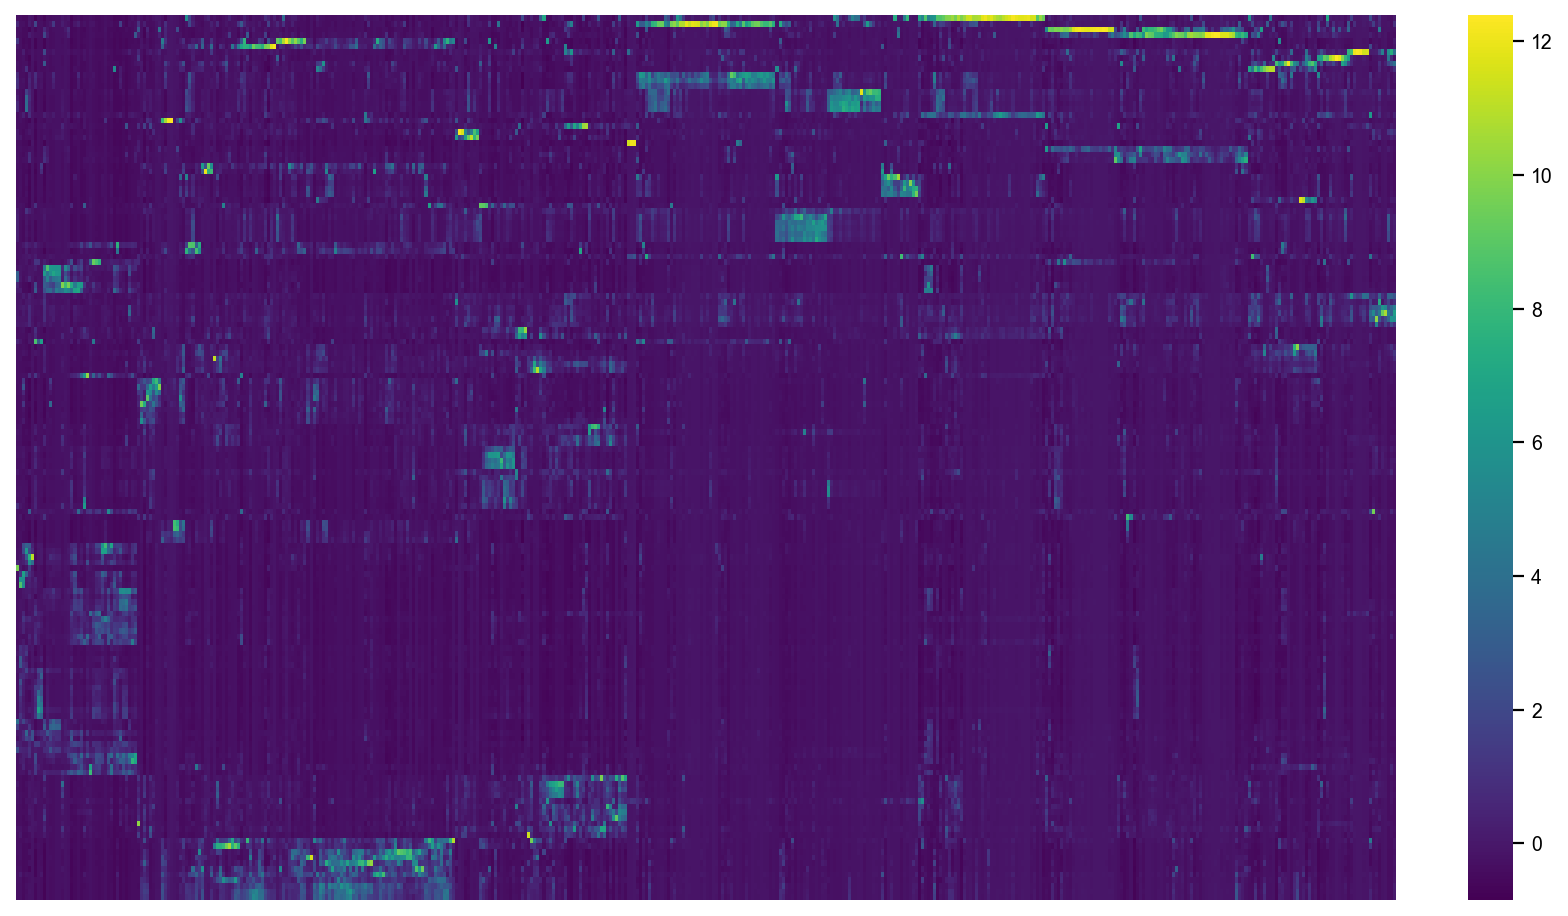

In [12]:
for genotype in ["Aire", "Fezf2"]:
    TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    filtered = filtered_genes[f"{genotype}_max_LFC"]
    TRA = filtered[filtered.index.isin(TRAs)]
    nonTRA = filtered[filtered.index.isin(nonTRAs)]
    cg = sns.clustermap(
        cell_type_expression[nonTRA.index],
        z_score=1,
        figsize=(14,8),
        col_cluster=True,
        row_cluster=True,
        cmap="viridis",
    )
    cg.ax_cbar.set_position([cg.ax_heatmap.get_position().bounds[2]+0.2, cg.ax_heatmap.get_position().bounds[1], 0.02, cg.ax_heatmap.get_position().height])
    cg.ax_heatmap.set_xticks([])
    cg.ax_heatmap.set_yticks([])
    cg.ax_heatmap.set_xlabel("")
    cg.ax_heatmap.set_ylabel("")
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    print(f"{genotype} non-TRA")
    plt.savefig(f"../analysis/paper_figures/3/3D_{genotype}_nonTRA_cellxgene_expression.png", dpi=300)
    plt.show()
    
    cg = sns.clustermap(
        cell_type_expression[TRA.index],
        z_score=1,
        figsize=(14,8),
        col_cluster=True,
        row_cluster=True,
        cmap="viridis",
    )
    cg.ax_cbar.set_position([cg.ax_heatmap.get_position().bounds[2]+0.2, cg.ax_heatmap.get_position().bounds[1], 0.02, cg.ax_heatmap.get_position().height])
    cg.ax_heatmap.set_xticks([])
    cg.ax_heatmap.set_yticks([])
    cg.ax_heatmap.set_xlabel("")
    cg.ax_heatmap.set_ylabel("")
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    print(f"{genotype} TRA")
    plt.savefig(f"../analysis/paper_figures/3/3D_{genotype}_TRA_cellxgene_expression.png", dpi=300)
    plt.show()

# Save

In [13]:
with open('../analysis/DE/filtered_genes.pkl', 'wb') as handle:
    pickle.dump(filtered_genes, handle)